# 统计方法与机器学习-实验报告8
温兆和 10205501432

在本周的实验中，我们将用逻辑斯蒂回归对diabetes数据集中的数据进行分类，并评价分类的效果。

首先，我们载入在本次实验中需要用到的Python包：

In [107]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy import io as scio
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

导入数据集并将其打开：

In [3]:
Data = datasets.load_diabetes()
print(Data)

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990749, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06833155, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286131, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04688253,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452873, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00422151,  0.00306441]]), 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
        69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
        68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
        87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
       259.,  53., 190., 142.,  75., 142., 155., 225.,  59., 104., 182.,
  

可以发现，这个数据集是字典形式的，它的三个key分别为data,feature_names和target。我们先对这个字典进行拆分并合成一个dataframe。

In [102]:
data = Data['data']
target = Data['target']
feature_names = Data['feature_names']
d_t = data
d_t=np.insert(d_t,10,target,axis = 1)
feature_names = np.append(feature_names,'trend')
DataFrame = pd.DataFrame(d_t,columns=feature_names)
dataframe = pd.DataFrame(d_t,columns=feature_names)
DataFrame.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,trend
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


这个数据集中自变量是糖尿病人的年龄、性别、血压等十个生理数据，因变量是病人一年后的糖尿病发展情况，样本量为$n=442$，研究的是病人的生理数据与一年后病情发展情况之间的关系。我们需要把这个问题转换成一个二分类问题，所以要把所有的因变量值分为两类。我们先找到因变量的中位数。

In [9]:
print(DataFrame['trend'].median())

140.5


所以，我们把所有$trend<140.5$的患者的$trend$设为$0$，所有$trend>=140.5$的患者的$trend$设为$1$。

In [10]:
for i in range (len(DataFrame)):
    if DataFrame['trend'][i]<140.5:
        DataFrame['trend'][i]=0
    else:
        DataFrame['trend'][i]=1
DataFrame.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,trend
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,1.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,0.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,1.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,1.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,0.0


下面，我们就可以用逻辑斯蒂回归模型对经过处理的数据集进行分类和预测了。逻辑斯蒂回归的基本思想就是，假设某个线性函数$wx$能把整个数据集分为两类，并通过极大似然估计法得到$w$的估计值$\hat{w}$。然后再计算后验概率
$$P(Y=1|x)=\frac{exp(\hat{w}x)}{1+exp(\hat{w}x)}$$
$$P(Y=0|x)=1-P(Y=1|x)$$
即当自变量$x$的值确定后这个自变量属于两个类类的概率。它属于哪一类的概率高，我们就认为它属于哪一类。
我们首先按照一定比例，把上述数据集分为训练集和测试集。

In [89]:
#设置样本量和自变量个数
p = 10
n = 442
#设置训练集和测试集的样本比例以及随机数种子
n_train = n*0.75 # 75% instances used for training
n_train=int(n_train)
n_test = n-n_train
seed = 19260817
random.seed(seed)
index = range(0,n)
index_selected = random.sample(index,n_train)
index_selected.sort()
#划分训练集和测试集
Data_train = DataFrame.loc[index_selected]
Data_test = DataFrame.drop(index = index_selected)

训练集为

In [90]:
Data_train.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,trend
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,1.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,0.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,1.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,1.0
5,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041176,-0.096346,0.0


测试集为

In [91]:
Data_test.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,trend
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,0.0
6,-0.045472,0.050680,-0.047163,-0.015999,-0.040096,-0.024800,0.000779,-0.039493,-0.062917,-0.038357,0.0
8,0.041708,0.050680,0.061696,-0.040099,-0.013953,0.006202,-0.028674,-0.002592,-0.014960,0.011349,0.0
15,-0.052738,0.050680,-0.018062,0.080401,0.089244,0.107662,-0.039719,0.108111,0.036060,-0.042499,1.0
17,0.070769,0.050680,0.012117,0.056301,0.034206,0.049416,-0.039719,0.034309,0.027364,-0.001078,1.0


将响应变量和自变量分离：

In [92]:
X_train = Data_train.drop(columns = ['trend'],axis = 1)
Y_train = Data_train.trend
X_test = Data_test.drop(columns = ["trend"],axis=1)
Y_test = Data_test.trend

建立逻辑斯蒂回归模型并在测试集上预测：

In [93]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train.values.reshape(-1))
Y_pred = logreg.predict(X_test)

计算逻辑斯蒂回归模型在测试集上的准确率：

In [94]:
print("The accuracy rate is: %2.3f" % accuracy_score(Y_test, Y_pred))

The accuracy rate is: 0.712


我们发现这个逻辑斯蒂回归模型的准确率为$0.712$。那么，为什么有些数据的预测出现错误了呢？我们试着改变训练集和测试集的比重，看看准确率会怎么样。

In [100]:
#0.8
n_train_1 = n*0.8 # 80% instances used for training
n_train_1=int(n_train_1)
n_test_1 = n-n_train_1
random.seed(seed)
index_1 = range(0,n)
index_selected_1 = random.sample(index_1,n_train_1)
index_selected_1.sort()
Data_train_1 = DataFrame.loc[index_selected_1]
Data_test_1 = DataFrame.drop(index = index_selected_1)
X_train_1 = Data_train_1.drop(columns = ['trend'],axis = 1)
Y_train_1 = Data_train_1.trend
X_test_1 = Data_test_1.drop(columns = ["trend"],axis=1)
Y_test_1 = Data_test_1.trend
logreg_1 = LogisticRegression()
logreg_1.fit(X_train_1, Y_train_1.values.reshape(-1))
Y_pred_1 = logreg.predict(X_test_1)
print("The accuracy rate is: %2.3f" % accuracy_score(Y_test_1, Y_pred_1))

The accuracy rate is: 0.697


In [101]:
#0.95
n_train_2 = n*0.95 # 95% instances used for training
n_train_2=int(n_train_2)
n_test_2 = n-n_train_2
random.seed(seed)
index_2 = range(0,n)
index_selected_2 = random.sample(index_2,n_train_2)
index_selected_2.sort()
Data_train_2 = DataFrame.loc[index_selected_2]
Data_test_2 = DataFrame.drop(index = index_selected_2)
X_train_2 = Data_train_2.drop(columns = ['trend'],axis = 1)
Y_train_2 = Data_train_2.trend
X_test_2 = Data_test_2.drop(columns = ["trend"],axis=1)
Y_test_2 = Data_test_2.trend
logreg_2 = LogisticRegression()
logreg_2.fit(X_train_2, Y_train_2.values.reshape(-1))
Y_pred_2 = logreg.predict(X_test_2)
print("The accuracy rate is: %2.3f" % accuracy_score(Y_test_2, Y_pred_2))

The accuracy rate is: 0.652


可以发现，当我们把训练集的占比调高，预测的准确率更低了。这有可能是因为训练集数据太多导致了过拟合或者数据集本身存在多重共线性，使得估计值$\hat{w}$变低。再者，逻辑斯蒂回归是根据自变量数据哪一类的概率大来对其进行分类的，自变量属于另一个类的概率不为$0$，所以这种方法本身就很难达到百分之百的正确率。此外，如果我们按照因变量中位数把原数据集分为两类，那一些因变量在中位数附近的点也可能被误分类。我们来看一看被误分类的点的因变量值都是多少。

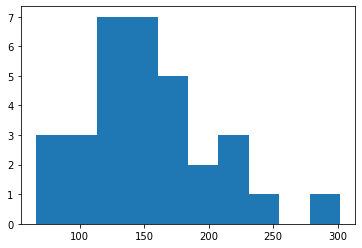

In [109]:
counter = 0
xs = []
indexlist = Y_test.index.tolist()
for i in indexlist:
    if Y_test[i]!=Y_pred[counter]:
        xs.append(dataframe['trend'][i])
    counter+=1
plt.hist(xs)
plt.show()

从上图我们可以看出，大部分被误分类的点都出现在因变量中位数$140.5$的周围。